In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install torch torchvision

In [3]:
!pip install DeepMIMOv3

In [4]:
!pip install DeepMIMO

In [5]:
import DeepMIMOv3
import DeepMIMO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

In [6]:
def get_deepMIMOdata(scenario='O1_60', dataset_folder=r'/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/HW_1'):
    # Load the default parameters
    parameters = DeepMIMO.default_params()

    # Set scenario name
    parameters['scenario'] = scenario #https://deepmimo.net/scenarios/o1-scenario/

    # Set the main folder containing extracted scenarios
    parameters['dataset_folder'] = dataset_folder #r'/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/HW_1'

    # To only include 10 strongest paths in the channel computation, set
    parameters['num_paths'] = 10

    # To activate only the first basestation, set
    parameters['active_BS'] = np.array([1])
    # To activate the basestations 6, set
    #parameters['active_BS'] = np.array([6])

    parameters['OFDM']['bandwidth'] = 0.05 # 50 MHz
    print(parameters['OFDM']['subcarriers']) #512
    #parameters['OFDM']['subcarriers'] = 512 # OFDM with 512 subcarriers
    #parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

    # To activate the user rows 1-5, set
    parameters['user_row_first'] = 1 #400 # First user row to be included in the dataset
    parameters['user_row_last'] = 100 #450 # Last user row to be included in the dataset

    # Consider 3 active basestations
    #parameters['active_BS'] = np.array([1, 5, 8])
    # Configuration of the antenna arrays
    parameters['bs_antenna']['shape'] = np.array([16, 1, 1]) # BS antenna shape through [x, y, z] axes
    parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # UE antenna shape through [x, y, z] axes, single antenna

    # The OFDM_channels parameter allows choosing between the generation of channel impulse
    # responses (if set to 0) or frequency domain channels (if set to 1).
    # It is set to 0 for this simulation, as the channel responses in frequency domain
    parameters['OFDM_channels'] = 0

    # Generate data
    DeepMIMO_dataset = DeepMIMO.generate_data(parameters)

    ## User locations
    active_bs_idx = 0 # Select the first active basestation in the dataset
    print(DeepMIMO_dataset[active_bs_idx]['user'].keys()) #['paths', 'LoS', 'location', 'distance', 'pathloss', 'channel']
    print(DeepMIMO_dataset[active_bs_idx]['user']['location'].shape) #(9231, 3)  num_ue_locations: 9231
    j=0 #user j
    print(DeepMIMO_dataset[active_bs_idx]['user']['location'][j]) #The Euclidian location of the user in the form of [x, y, z].

    # Number of basestations
    print(len(DeepMIMO_dataset)) #1
    # Keys of a basestation dictionary
    print(DeepMIMO_dataset[0].keys()) #['user', 'basestation', 'location']
    # Keys of a channel
    print(DeepMIMO_dataset[0]['user'].keys()) #['paths', 'LoS', 'location', 'distance', 'pathloss', 'channel']
    # Number of UEs
    print(len(DeepMIMO_dataset[0]['user']['channel'])) #9231
    print(DeepMIMO_dataset[active_bs_idx]['user']['channel'].shape) #(num_ue_locations=9231, 1, bs_antenna=16, strongest_path=10)
    # Shape of the channel matrix
    print(DeepMIMO_dataset[0]['user']['channel'].shape) #(9231, 1, 16, 10)

    i=0
    j=0
    #The channel matrix between basestation i and user j
    DeepMIMO_dataset[i]['user']['channel'][j]
    #Float matrix of size (number of RX antennas) x (number of TX antennas) x (number of OFDM subcarriers)

    # Shape of BS 0 - UE 0 channel
    print(DeepMIMO_dataset[i]['user']['channel'][0].shape) #(1, 16, 10)

    # Path properties of BS 0 - UE 0
    print(DeepMIMO_dataset[i]['user']['paths'][j]) #Ray-tracing Path Parameters in dictionary
    #Azimuth and zenith angle-of-arrivals – degrees (DoA_phi, DoA_theta)
    # Azimuth and zenith angle-of-departure – degrees (DoD_phi, DoD_theta)
    # Time of arrival – seconds (ToA)
    # Phase – degrees (phase)
    # Power – watts (power)
    # Number of paths (num_paths)

    print(DeepMIMO_dataset[i]['user']['LoS'][j]) #Integer of values {-1, 0, 1} indicates the existence of the LOS path in the channel.
    # (1): The LoS path exists.
    # (0): Only NLoS paths exist. The LoS path is blocked (LoS blockage).
    # (-1): No paths exist between the transmitter and the receiver (Full blockage).

    print(DeepMIMO_dataset[i]['user']['distance'][j])
    #The Euclidian distance between the RX and TX locations in meters.

    print(DeepMIMO_dataset[i]['user']['pathloss'][j])
    #The combined path-loss of the channel between the RX and TX in dB.


    print(DeepMIMO_dataset[i]['location'])
    #Basestation Location [x, y, z].
    print(DeepMIMO_dataset[i]['user']['location'][j])
    #The Euclidian location of the user in the form of [x, y, z].

    plt.figure(figsize=(12,8))
    plt.scatter(DeepMIMO_dataset[active_bs_idx]['user']['location'][:, 1], # y-axis location of the users
            DeepMIMO_dataset[active_bs_idx]['user']['location'][:, 0], # x-axis location of the users
            s=1, marker='x', c='C0', label='The users located on the rows %i to %i (R%i to R%i)'%
            (parameters['user_row_first'], parameters['user_row_last'],
            parameters['user_row_first'], parameters['user_row_last']))
    # First 181 users correspond to the first row
    plt.scatter(DeepMIMO_dataset[active_bs_idx]['user']['location'][0:181, 1],
            DeepMIMO_dataset[active_bs_idx]['user']['location'][0:181, 0],
            s=1, marker='x', c='C1', label='First row of users (R%i)'% (parameters['user_row_first']))

    ## Basestation location
    plt.scatter(DeepMIMO_dataset[active_bs_idx]['location'][1],
            DeepMIMO_dataset[active_bs_idx]['location'][0],
            s=50.0, marker='o', c='C2', label='Basestation')

    plt.gca().invert_xaxis() # Invert the x-axis to align the figure with the figure above
    plt.ylabel('x-axis')
    plt.xlabel('y-axis')
    plt.grid()
    plt.legend();

    dataset = DeepMIMO_dataset
    ## Visualization of a channel matrix
    plt.figure()
    # Visualize channel magnitude response
    # First, select indices of a user and bs
    ue_idx = 0
    bs_idx = 0
    # Import channel
    channel = dataset[bs_idx]['user']['channel'][ue_idx]
    # Take only the first antenna pair
    plt.imshow(np.abs(np.squeeze(channel).T))
    plt.title('Channel Magnitude Response')
    plt.xlabel('TX Antennas')
    plt.ylabel('Subcarriers')

    ## Visualization of the UE positions and path-losses
    loc_x = dataset[bs_idx]['user']['location'][:, 0] #(9231,)
    loc_y = dataset[bs_idx]['user']['location'][:, 1]
    loc_z = dataset[bs_idx]['user']['location'][:, 2]
    pathloss = dataset[bs_idx]['user']['pathloss'] #(9231,
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    im = ax.scatter(loc_x, loc_y, loc_z, c=pathloss)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')

    bs_loc_x = dataset[bs_idx]['basestation']['location'][:, 0]
    bs_loc_y = dataset[bs_idx]['basestation']['location'][:, 1]
    bs_loc_z = dataset[bs_idx]['basestation']['location'][:, 2]
    ax.scatter(bs_loc_x, bs_loc_y, bs_loc_z, c='r')
    ttl = plt.title('UE and BS Positions')

    fig = plt.figure()
    ax = fig.add_subplot()
    im = ax.scatter(loc_x, loc_y, c=pathloss)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    fig.colorbar(im, ax=ax)
    ttl = plt.title('UE Grid Path-loss (dB)')

    return DeepMIMO_dataset

In [7]:
'''
Add Channel Correponed Binary Inforamtion for __getitem__ function
'''
def find_nearest_constellation_point(complex_number):
    constellation = np.array([
    1 + 1j,
    1 - 1j,
    -1 + 1j,
    -1 - 1j
        ])
    distances = np.abs(constellation - complex_number)
    nearest_index = np.argmin(distances)
    return nearest_index

def constellation_point_array(complex_array):
  # Map the complex numbers to their constellation points
  binary_values = np.zeros((16,20), dtype=int)
  for i in range(16):
    for j in range(10):
      number = complex_array[0][i][j]
      index = find_nearest_constellation_point(number)
      b_info = format(index, '02b')
      binary_values[i][j*2]=(int(b_info[0]))
      binary_values[i][j*2+1]=(int(b_info[1]))

  return binary_values

In [8]:
'''
Add Channel Correponed Binary Inforamtion for __getitem__ function
'''
# Input: DeepMIMO dataset, UE and BS indices to be included
#
# For a given 1D vector of BS or UE indices, the generated dataset will be stacked as different samples
#
# By default, the adapter will only select the first BS of the DeepMIMO dataset and all UEs
# The adapter assumes BSs are transmitters and users are receivers.
# Uplink channels could be generated using (transpose) reciprocity.
#
# For multi-user channels, provide a 2D numpy matrix of size (num_samples x num_rx)
#
# Examples:
# ue_idx = np.array([[0, 1 ,2], [1, 2, 3]]) generates (num_bs x 3 UEs) channels
# with 2 data samples from the BSs to the UEs [0, 1, 2] and [1, 2, 3], respectively.
#
# For single-basestation channels with the data from different basestations stacked,
# provide a 1D array of basestation indices
#
# For multi-BS channels, provide a 2D numpy matrix of (num_samples x num_tx)
#
# Examples:
# bs_idx = np.array([[0, 1], [2, 3], [4, 5]]) generates (2 BSs x num_rx) channels
# by stacking the data of channels from the basestations (0 and 1), (2 and 3),
# and (4 and 5) to the UEs.
#
class DeepMIMODataset(Dataset):
    def __init__(self, DeepMIMO_dataset, bs_idx = None, ue_idx = None):
        self.dataset = DeepMIMO_dataset
        # Set bs_idx based on given parameters
        # If no input is given, choose the first basestation
        if bs_idx is None:
            bs_idx = np.array([[0]])
        self.bs_idx = self._verify_idx(bs_idx)

        # Set ue_idx based on given parameters
        # If no input is given, set all user indices
        if ue_idx is None:
            ue_idx = np.arange(DeepMIMO_dataset[0]['user']['channel'].shape[0])
        self.ue_idx = self._verify_idx(ue_idx) #(9231, 1)

        # Extract number of antennas from the DeepMIMO dataset
        self.num_rx_ant = DeepMIMO_dataset[0]['user']['channel'].shape[1] #1
        self.num_tx_ant = DeepMIMO_dataset[0]['user']['channel'].shape[2] #16

        # Determine the number of samples based on the given indices
        self.num_samples_bs = self.bs_idx.shape[0] #1
        self.num_samples_ue = self.ue_idx.shape[0] #9231
        self.num_samples = self.num_samples_bs * self.num_samples_ue #9231

        # Determine the number of tx and rx elements in each channel sample based on the given indices
        self.num_rx = self.ue_idx.shape[1] #1
        self.num_tx = self.bs_idx.shape[1] #1

        # Determine the number of available paths in the DeepMIMO dataset
        self.num_paths = DeepMIMO_dataset[0]['user']['channel'].shape[-1] #10
        self.num_time_steps = 1 # Time step = 1 for static scenarios

        # The required path power shape
        self.ch_shape = (self.num_rx,
                         self.num_rx_ant,
                         self.num_tx,
                         self.num_tx_ant,
                         self.num_paths,
                         self.num_time_steps) #(rx=1, rx_ant=1, tx=1, tx_ant=16, paths=10, timestesp=1)

        self.b_info = (self.num_rx,
                         self.num_rx_ant,
                         self.num_tx,
                         self.num_tx_ant,
                         self.num_paths*2,
                         self.num_time_steps) #(rx=1, rx_ant=1, tx=1, tx_ant=16, paths=10, timestesp=1)

        # The required path delay shape
        self.t_shape = (self.num_rx, self.num_tx, self.num_paths) #(rx=1,tx=1,paths=10)


    def __getitem__(self, index):
        ue_idx = index // self.num_samples_bs
        bs_idx = index % self.num_samples_bs
        # Generate zero vectors
        a = np.zeros(self.ch_shape, dtype=np.csingle)
        tau = np.zeros(self.t_shape, dtype=np.single)
        info_b = np.zeros(self.b_info, dtype=int)

        # Place the DeepMIMO dataset power and delays into the channel sample
        for i_ch in range(self.num_rx): # for each receiver in the sample
            for j_ch in range(self.num_tx): # for each transmitter in the sample
                i_ue = self.ue_idx[ue_idx][i_ch] # UE channel sample i - channel RX i_ch
                i_bs = self.bs_idx[bs_idx][j_ch] # BS channel sample i - channel TX j_ch
                a[i_ch, :, j_ch, :, :, 0] = self.dataset[i_bs]['user']['channel'][i_ue]
                tau[i_ch, j_ch, :self.dataset[i_bs]['user']['paths'][i_ue]['num_paths']] = self.dataset[i_bs]['user']['paths'][i_ue]['ToA']
                info_b[i_ch, 0, j_ch, :,:,0] = constellation_point_array(self.dataset[i_bs]['user']['channel'][i_ue])
        return a, tau, info_b ## yield this sample h=(num_rx=1, 1, num_tx=1, 16, 10, 1), tau=(num_rx=1,num_tx=1,ToA=10)

    def __len__(self):
        return self.num_samples

    # Verify the index values given as input
    def _verify_idx(self, idx):
        idx = self._idx_to_numpy(idx)
        idx = self._numpy_size_check(idx)
        return idx

    # Convert the possible input types to numpy (integer - range - list)
    def _idx_to_numpy(self, idx):
        if isinstance(idx, int): # If the input is an integer - a single ID - convert it to 2D numpy array
            idx = np.array([[idx]])
        elif isinstance(idx, list) or isinstance(idx, range): # If the input is a list or range - convert it to a numpy array
            idx = np.array(idx)
        elif isinstance(idx, np.ndarray):
            pass
        else:
            raise TypeError('The index input type must be an integer, list, or numpy array!')
        return idx

    # Check the size of the given input and convert it to a 2D matrix of proper shape (num_tx x num_samples) or (num_rx x num_samples)
    def _numpy_size_check(self, idx):
        if len(idx.shape) == 1:
            idx = idx.reshape((-1, 1))
        elif len(idx.shape) == 2:
            pass
        else:
            raise ValueError('The index input must be integer, vector or 2D matrix!')
        return idx

    # Override length of the generator to provide the available number of samples
    def __len__(self):
        return self.num_samples

512

Basestation 1

UE-BS Channels


Generating channels: 100%|██████████| 18100/18100 [00:04<00:00, 3922.41it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 313.62it/s]


dict_keys(['paths', 'LoS', 'location', 'distance', 'pathloss', 'channel'])
(18100, 3)
[242.42300415 297.17098999   2.        ]
1
dict_keys(['user', 'basestation', 'location'])
dict_keys(['paths', 'LoS', 'location', 'distance', 'pathloss', 'channel'])
18100
(18100, 1, 16, 10)
(18100, 1, 16, 10)
(1, 16, 10)
{'num_paths': 9, 'DoD_phi': array([ -85.7145,  -85.7145, -100.538 , -142.427 , -100.538 , -142.427 ,
        -40.3649,  -40.3649, -159.858 ], dtype=float32), 'DoD_theta': array([92.4737, 94.4464, 92.4413, 91.5279, 94.8737, 92.7487, 91.6071,
       92.8912, 90.8809], dtype=float32), 'DoA_phi': array([ 94.2855,  94.2855, 100.091 ,  38.0195, 100.091 ,  38.0195,
        40.3649,  40.3649,  21.0355], dtype=float32), 'DoA_theta': array([87.5263, 94.4464, 87.5587, 88.4721, 94.8737, 92.7487, 88.3929,
       92.8912, 89.1191], dtype=float32), 'phase': array([ 107.753  , -155.331  ,   -6.7413 ,  -40.4364 ,   91.2444 ,
       -131.379  ,  139.119  ,   66.7524 ,   -5.63794], dtype=float32), 'ToA'

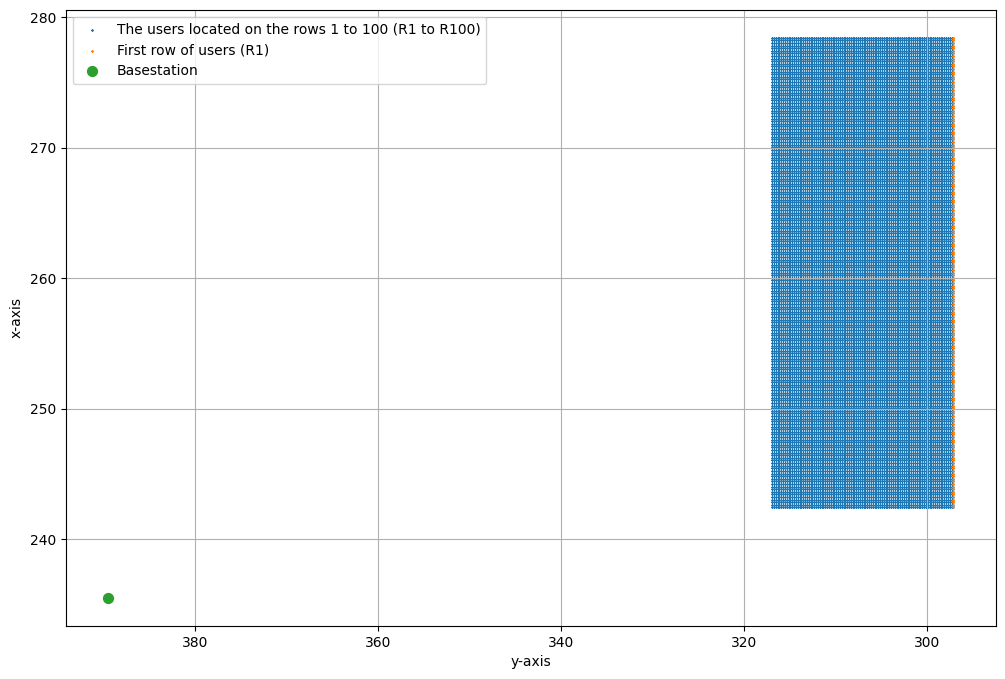

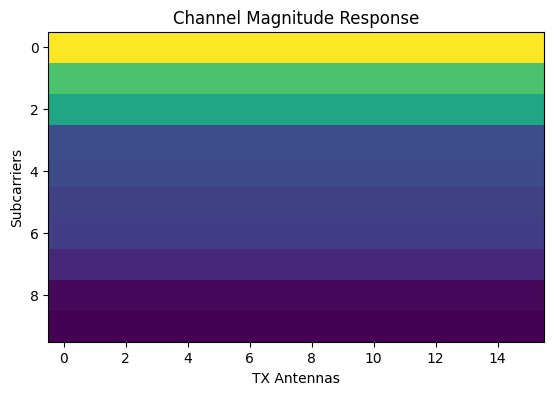

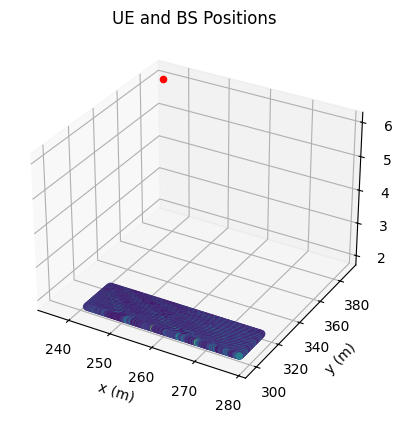

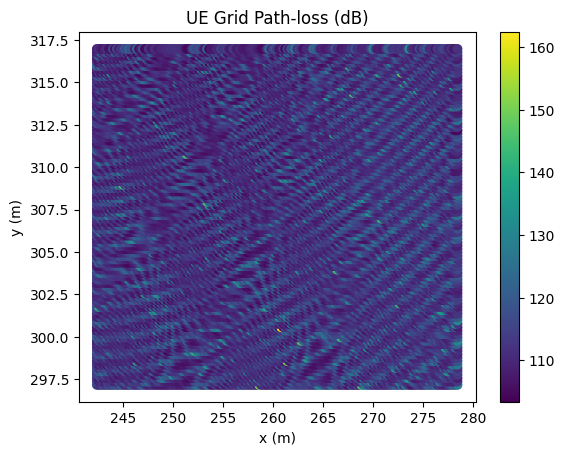

In [9]:
scenario= 'O1_140'
# Put your path to data
dataset_folder=r'/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/HW_1'

dataset = get_deepMIMOdata(scenario,dataset_folder)

In [10]:
# Number of receivers for the model.
# MISO is considered here.
num_rx = 1
num_tx = 1 #new add
batch_size = 64
fft_size = 76
# The number of UE locations in the generated DeepMIMO dataset
num_ue_locations = len(dataset[0]['user']['channel']) #18100
print(num_ue_locations)
# Pick the largest possible number of user locations that is a multiple of ``num_rx``
ue_idx = np.arange(num_rx*(num_ue_locations//num_rx)) #(9231,) 0~18099
print(ue_idx)
np.random.shuffle(ue_idx)
# Reshape to fit the requested number of users
ue_idx = np.reshape(ue_idx, [-1, num_rx]) # In the shape of (floor(9231/num_rx) x num_rx) (18099,1)

18100
[    0     1     2 ... 18097 18098 18099]


In [11]:
testdataset = DeepMIMODataset(DeepMIMO_dataset=dataset, ue_idx=ue_idx)
h, _, info_b= next(iter(testdataset)) #h: (1, 1, 1, 16, 10, 1), _, info_b (1, 1, 1, 16, 20, 1)

In [12]:
# torch dataloaders
data_loader = DataLoader(dataset=testdataset, batch_size=batch_size, shuffle=True, pin_memory=True)
h_b, tau_b, b_info_b = next(iter(data_loader)) #h_b: [64, 1, 1, 1, 16, 10, 1], tau_b=[64, 1, 1, 10]
print(h_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print(b_info_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths*2, num_time_steps]

torch.Size([64, 1, 1, 1, 16, 10, 1])
torch.Size([64, 1, 1, 1, 16, 20, 1])


In [13]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [14]:
# train, validation and test split
train_size = int(0.8 * len(testdataset))
val_size = len(testdataset) - train_size
train_set, val_set= torch.utils.data.random_split(testdataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)

In [15]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super(BaseLineModel, self).__init__()
        scale = 4  # Increase for a more complex model
        input_size = 16 * 10 * 2  # Considering both real and imaginary parts

        # Define a series of fully connected layers with ReLU activations
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(input_size, scale * 256)  # First hidden layer
        self.fc2 = nn.Linear(scale * 256, scale * 128)  # Second hidden layer
        self.fc3 = nn.Linear(scale * 128, scale * 64)  # Third hidden layer
        self.fc4 = nn.Linear(scale * 64, 16 * 20 * 1)  # Output layer

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [64, 1, 1, 1, 16, 10, 1], dtype=torch.cfloat

        # Extract the real and imaginary parts of the complex input
        real_part = x.real  # Shape: [64, 1, 1, 1, 16, 10, 1]
        imag_part = x.imag  # Shape: [64, 1, 1, 1, 16, 10, 1]

        # Concatenate the real and imaginary parts along the last dimension
        x = torch.cat((real_part, imag_part), dim=-1)  # Shape: [64, 1, 1, 1, 16, 10, 2]

        # Flatten the unnecessary dimensions and keep only the last two dimensions
        x = x.squeeze(1).squeeze(1).squeeze(1)  # Shape: [64, 16, 10, 2]
        x = self.flatten(x)  # Shape: [64, 16 * 10 * 2]

        # Pass the data through the deeper network
        x = self.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = self.relu(self.fc2(x))  # Second fully connected layer with ReLU
        x = self.relu(self.fc3(x))  # Third fully connected layer with ReLU
        x = self.fc4(x)  # Output layer

        # Reshape the output to match the desired shape: [64, 1, 1, 1, 16, 20, 1]
        x = x.view(-1, 1, 1, 1, 16, 20, 1)  # Use view to reshape the output
        return self.sigmoid(x)

In [16]:
class DropOutModel(nn.Module):
    def __init__(self):
        super(DropOutModel, self).__init__()
        scale = 4  # Increase for a more complex model
        input_size = 16 * 10 * 2  # Considering both real and imaginary parts

        # Define a series of fully connected layers with ReLU activations
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(input_size, scale * 256)  # First hidden layer
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(scale * 256, scale * 128)  # Second hidden layer
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(scale * 128, scale * 64)  # Third hidden layer
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(scale * 64, 16 * 20 * 1)  # Output layer

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [64, 1, 1, 1, 16, 10, 1], dtype=torch.cfloat

        # Extract the real and imaginary parts of the complex input
        real_part = x.real  # Shape: [64, 1, 1, 1, 16, 10, 1]
        imag_part = x.imag  # Shape: [64, 1, 1, 1, 16, 10, 1]

        # Concatenate the real and imaginary parts along the last dimension
        x = torch.cat((real_part, imag_part), dim=-1)  # Shape: [64, 1, 1, 1, 16, 10, 2]

        # Flatten the unnecessary dimensions and keep only the last two dimensions
        x = x.squeeze(1).squeeze(1).squeeze(1)  # Shape: [64, 16, 10, 2]
        x = self.flatten(x)  # Shape: [64, 16 * 10 * 2]

        # Pass the data through the deeper network
        x = self.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))  # Second fully connected layer with ReLU
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))  # Third fully connected layer with ReLU
        x = self.dropout3(x)
        x = self.fc4(x)  # Output layer

        # Reshape the output to match the desired shape: [64, 1, 1, 1, 16, 20, 1]
        x = x.view(-1, 1, 1, 1, 16, 20, 1)  # Use view to reshape the output
        return self.sigmoid(x)

In [17]:
class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        scale = 4  # Increase for a more complex model
        input_size = 16 * 10 * 2  # Considering both real and imaginary parts

        # Define a series of fully connected layers with ReLU activations
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(input_size, scale * 256)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(scale * 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(scale * 256, scale * 128)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(scale * 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(scale * 128, scale * 64)  # Third hidden layer
        self.bn3 = nn.BatchNorm1d(scale * 64)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(scale * 64, 16 * 20 * 1)  # Output layer

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [64, 1, 1, 1, 16, 10, 1], dtype=torch.cfloat

        # Extract the real and imaginary parts of the complex input
        real_part = x.real  # Shape: [64, 1, 1, 1, 16, 10, 1]
        imag_part = x.imag  # Shape: [64, 1, 1, 1, 16, 10, 1]

        # Concatenate the real and imaginary parts along the last dimension
        x = torch.cat((real_part, imag_part), dim=-1)  # Shape: [64, 1, 1, 1, 16, 10, 2]

        # Flatten the unnecessary dimensions and keep only the last two dimensions
        x = x.squeeze(1).squeeze(1).squeeze(1)  # Shape: [64, 16, 10, 2]
        x = self.flatten(x)  # Shape: [64, 16 * 10 * 2]

        # Pass the data through the deeper network
        x = self.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))  # Second fully connected layer with ReLU
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))  # Third fully connected layer with ReLU
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.fc4(x)  # Output layer

        # Reshape the output to match the desired shape: [64, 1, 1, 1, 16, 20, 1]
        x = x.view(-1, 1, 1, 1, 16, 20, 1)  # Use view to reshape the output
        return self.sigmoid(x)

In [49]:
class LessComplexModel(nn.Module):
    def __init__(self):
        super(LessComplexModel, self).__init__()
        scale = 1  # Increase for a more complex model
        input_size = 16 * 10 * 2  # Considering both real and imaginary parts

        # Define a series of fully connected layers with ReLU activations
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(input_size, scale * 256)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(scale * 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(scale * 256, scale * 128)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(scale * 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(scale * 128, 16 * 20 * 1)  # Output layer

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [64, 1, 1, 1, 16, 10, 1], dtype=torch.cfloat

        # Extract the real and imaginary parts of the complex input
        real_part = x.real  # Shape: [64, 1, 1, 1, 16, 10, 1]
        imag_part = x.imag  # Shape: [64, 1, 1, 1, 16, 10, 1]

        # Concatenate the real and imaginary parts along the last dimension
        x = torch.cat((real_part, imag_part), dim=-1)  # Shape: [64, 1, 1, 1, 16, 10, 2]

        # Flatten the unnecessary dimensions and keep only the last two dimensions
        x = x.squeeze(1).squeeze(1).squeeze(1)  # Shape: [64, 16, 10, 2]
        x = self.flatten(x)  # Shape: [64, 16 * 10 * 2]

        # Pass the data through the deeper network
        x = self.relu(self.fc1(x))  # First fully connected layer with ReLU
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))  # Second fully connected layer with ReLU
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)  # Output layer

        # Reshape the output to match the desired shape: [64, 1, 1, 1, 16, 20, 1]
        x = x.view(-1, 1, 1, 1, 16, 20, 1)  # Use view to reshape the output
        return self.sigmoid(x)

In [25]:
'''
Baseline Training
'''
torch.cuda.empty_cache()
model =  BaseLineModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 20
loss_values = []
BER_values = []
val_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, _, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]  # Bit Error Rate
    with torch.no_grad():
        for inputs, _, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != targets).float()  # Count of unequal bits
            error_rate = error_count / len(targets.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())

    scheduler.step() #adjust learning rate
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    val_values.append(val_loss.item())
    BER_avg=np.mean(BER_batch)
    BER_values.append(BER_avg)
    print(f"Epoch {epoch + 1}/{num_epochs}, Trainig_Loss: {avg_loss:.4f}, Val_loss: {val_loss:.4f}, BER: {BER_avg:.4f}")
torch.save(model.state_dict(), '/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/models/BaseLineModel.pth')

Epoch 1/20, Trainig_Loss: 0.1101, Val_loss: 0.1059, BER: 0.3814
Epoch 2/20, Trainig_Loss: 0.1092, Val_loss: 0.1234, BER: 0.3808
Epoch 3/20, Trainig_Loss: 0.1092, Val_loss: 0.1438, BER: 0.3807
Epoch 4/20, Trainig_Loss: 0.1091, Val_loss: 0.1215, BER: 0.3809
Epoch 5/20, Trainig_Loss: 0.1091, Val_loss: 0.1209, BER: 0.3821
Epoch 6/20, Trainig_Loss: 0.1091, Val_loss: 0.1059, BER: 0.3815
Epoch 7/20, Trainig_Loss: 0.1091, Val_loss: 0.1184, BER: 0.3815
Epoch 8/20, Trainig_Loss: 0.1091, Val_loss: 0.1070, BER: 0.3816
Epoch 9/20, Trainig_Loss: 0.1091, Val_loss: 0.0821, BER: 0.3816
Epoch 10/20, Trainig_Loss: 0.1091, Val_loss: 0.0818, BER: 0.3816
Epoch 11/20, Trainig_Loss: 0.1091, Val_loss: 0.1066, BER: 0.3819
Epoch 12/20, Trainig_Loss: 0.1091, Val_loss: 0.0905, BER: 0.3818
Epoch 13/20, Trainig_Loss: 0.1091, Val_loss: 0.0822, BER: 0.3818
Epoch 14/20, Trainig_Loss: 0.1090, Val_loss: 0.0819, BER: 0.3818
Epoch 15/20, Trainig_Loss: 0.1091, Val_loss: 0.1064, BER: 0.3818
Epoch 16/20, Trainig_Loss: 0.1091,

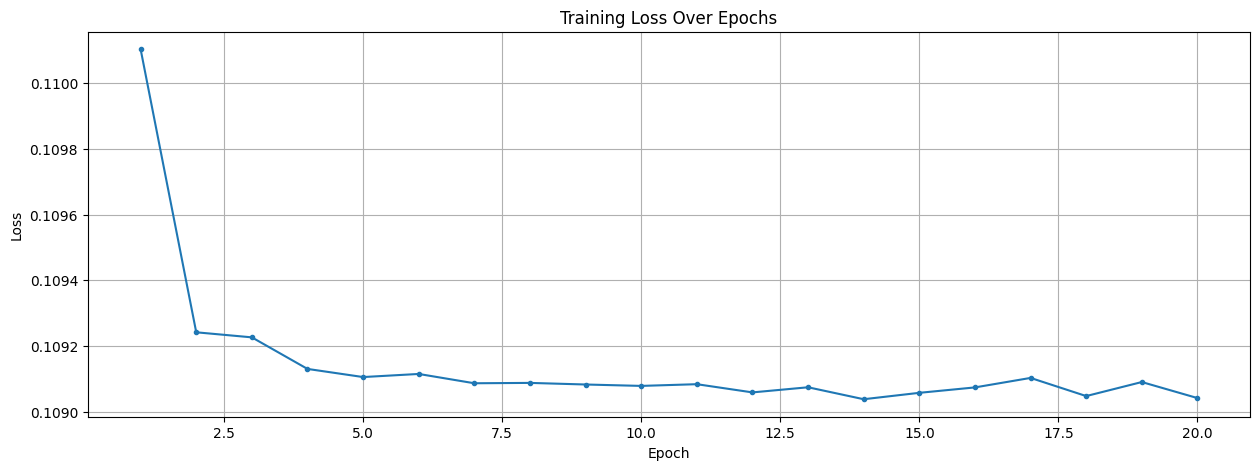

In [29]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

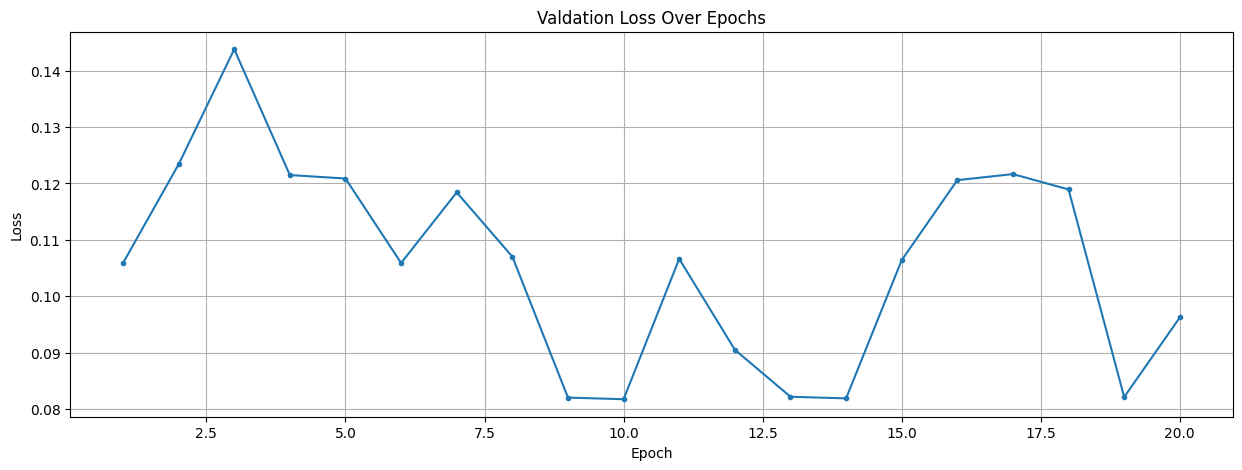

In [30]:
# Plot the Validation loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), val_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Valdation Loss Over Epochs')
plt.grid(True)
plt.show()

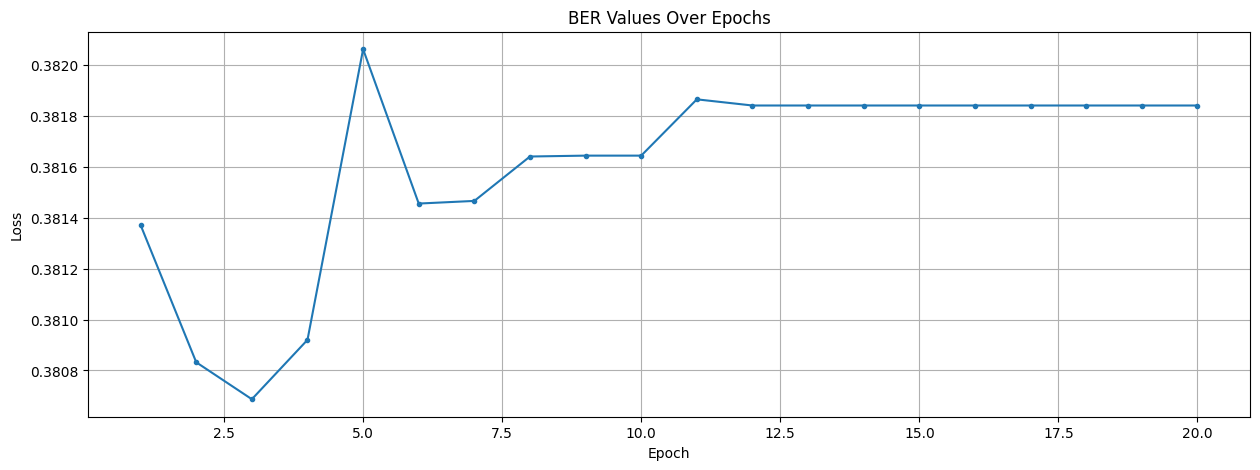

In [31]:
# Plot the BER
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), BER_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BER Values Over Epochs')
plt.grid(True)
plt.show()

In [39]:
'''
Drop Out Model
'''
torch.cuda.empty_cache()
model = DropOutModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 20
DropOutModel_loss_values = []
DropOutModel_BER_values = []
DropOutModel_val_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, _, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets.float())  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]  # Bit Error Rate
    with torch.no_grad():
        for inputs, _, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets.float())

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != targets).float()  # Count of unequal bits
            error_rate = error_count / len(targets.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())

    scheduler.step() #adjust learning rate
    avg_loss = running_loss / len(train_loader)
    DropOutModel_loss_values.append(avg_loss)
    DropOutModel_val_values.append(val_loss.item())
    BER_avg=np.mean(BER_batch)
    DropOutModel_BER_values.append(BER_avg)
    print(f"Epoch {epoch + 1}/{num_epochs}, Trainig_Loss: {avg_loss:.4f}, Val_loss: {val_loss:.4f}, BER: {BER_avg:.4f}")
torch.save(model.state_dict(), '/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/models/DropOutModel.pth')

Epoch 1/20, Trainig_Loss: 0.1104, Val_loss: 0.1379, BER: 0.3819
Epoch 2/20, Trainig_Loss: 0.1094, Val_loss: 0.0816, BER: 0.3812
Epoch 3/20, Trainig_Loss: 0.1093, Val_loss: 0.0981, BER: 0.3813
Epoch 4/20, Trainig_Loss: 0.1092, Val_loss: 0.0969, BER: 0.3816
Epoch 5/20, Trainig_Loss: 0.1092, Val_loss: 0.0816, BER: 0.3819
Epoch 6/20, Trainig_Loss: 0.1092, Val_loss: 0.1060, BER: 0.3819
Epoch 7/20, Trainig_Loss: 0.1091, Val_loss: 0.1075, BER: 0.3820
Epoch 8/20, Trainig_Loss: 0.1092, Val_loss: 0.0820, BER: 0.3818
Epoch 9/20, Trainig_Loss: 0.1092, Val_loss: 0.1411, BER: 0.3818
Epoch 10/20, Trainig_Loss: 0.1092, Val_loss: 0.1060, BER: 0.3818
Epoch 11/20, Trainig_Loss: 0.1092, Val_loss: 0.0967, BER: 0.3818
Epoch 12/20, Trainig_Loss: 0.1092, Val_loss: 0.1053, BER: 0.3818
Epoch 13/20, Trainig_Loss: 0.1092, Val_loss: 0.1450, BER: 0.3818
Epoch 14/20, Trainig_Loss: 0.1092, Val_loss: 0.1213, BER: 0.3818
Epoch 15/20, Trainig_Loss: 0.1092, Val_loss: 0.1042, BER: 0.3818
Epoch 16/20, Trainig_Loss: 0.1092,

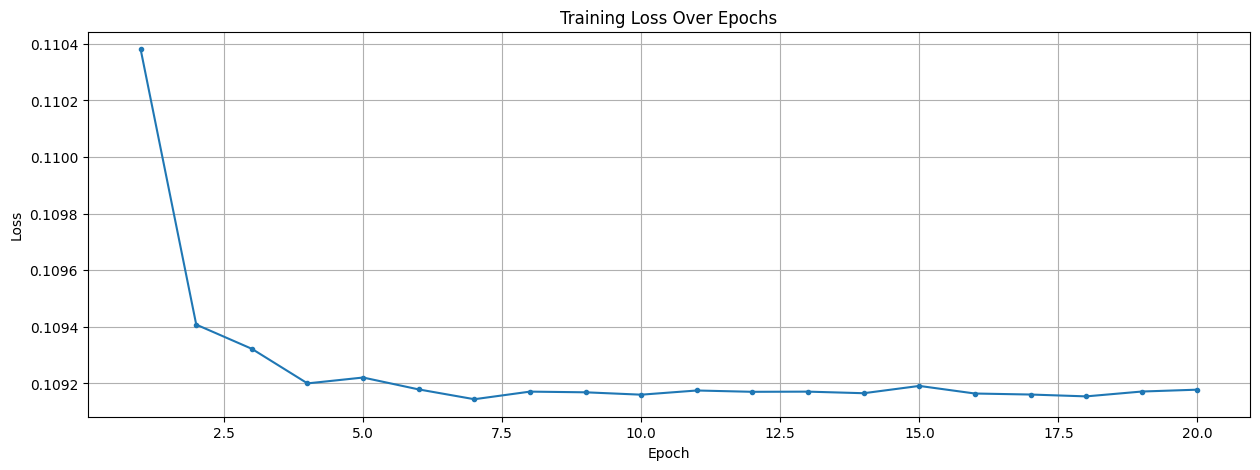

In [40]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), DropOutModel_loss_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

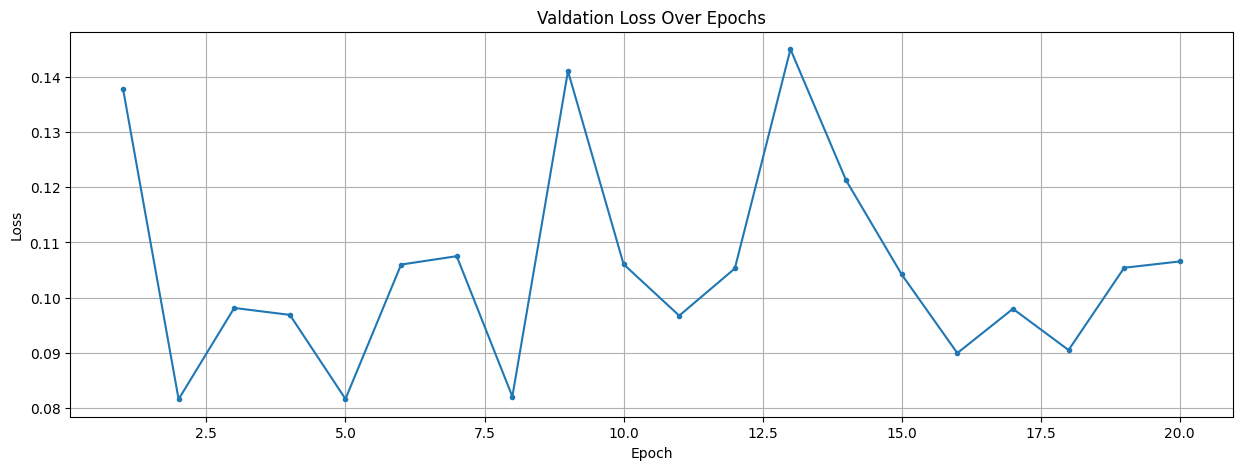

In [41]:
# Plot the validation loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), DropOutModel_val_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Valdation Loss Over Epochs')
plt.grid(True)
plt.show()

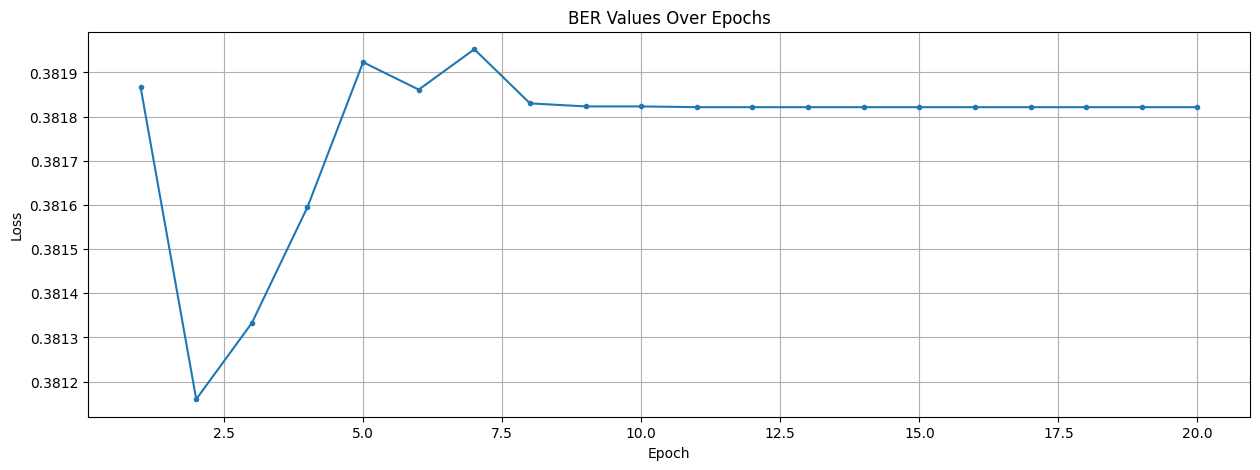

In [42]:
# Plot the BER
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), DropOutModel_BER_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BER Values Over Epochs')
plt.grid(True)
plt.show()

In [43]:
'''
Batch Norm Model
'''
torch.cuda.empty_cache()
model = BatchNormModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 20
BatchNormModel_loss_values = []
BatchNormModel_BER_values = []
BatchNormModel_val_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, _, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets.float())  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]  # Bit Error Rate
    with torch.no_grad():
        for inputs, _, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets.float())

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != targets).float()  # Count of unequal bits
            error_rate = error_count / len(targets.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())

    scheduler.step() #adjust learning rate
    avg_loss = running_loss / len(train_loader)
    BatchNormModel_loss_values.append(avg_loss)
    BatchNormModel_val_values.append(val_loss.item())
    BER_avg=np.mean(BER_batch)
    BatchNormModel_BER_values.append(BER_avg)
    print(f"Epoch {epoch + 1}/{num_epochs}, Trainig_Loss: {avg_loss:.4f}, Val_loss: {val_loss:.4f}, BER: {BER_avg:.4f}")
torch.save(model.state_dict(), '/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/models/DropOutModel.pth')

Epoch 1/20, Trainig_Loss: 0.1208, Val_loss: 0.2054, BER: 0.4638
Epoch 2/20, Trainig_Loss: 0.1108, Val_loss: 0.1256, BER: 0.4201
Epoch 3/20, Trainig_Loss: 0.1100, Val_loss: 0.1286, BER: 0.4503
Epoch 4/20, Trainig_Loss: 0.1088, Val_loss: 0.1435, BER: 0.3690
Epoch 5/20, Trainig_Loss: 0.1084, Val_loss: 0.1313, BER: 0.3687
Epoch 6/20, Trainig_Loss: 0.1081, Val_loss: 0.1328, BER: 0.3678
Epoch 7/20, Trainig_Loss: 0.1079, Val_loss: 0.0902, BER: 0.3684
Epoch 8/20, Trainig_Loss: 0.1079, Val_loss: 0.1029, BER: 0.3683
Epoch 9/20, Trainig_Loss: 0.1078, Val_loss: 0.0825, BER: 0.3683
Epoch 10/20, Trainig_Loss: 0.1078, Val_loss: 0.0898, BER: 0.3684
Epoch 11/20, Trainig_Loss: 0.1078, Val_loss: 0.1434, BER: 0.3683
Epoch 12/20, Trainig_Loss: 0.1078, Val_loss: 0.0891, BER: 0.3681
Epoch 13/20, Trainig_Loss: 0.1078, Val_loss: 0.0900, BER: 0.3683
Epoch 14/20, Trainig_Loss: 0.1078, Val_loss: 0.1377, BER: 0.3683
Epoch 15/20, Trainig_Loss: 0.1078, Val_loss: 0.0999, BER: 0.3683
Epoch 16/20, Trainig_Loss: 0.1077,

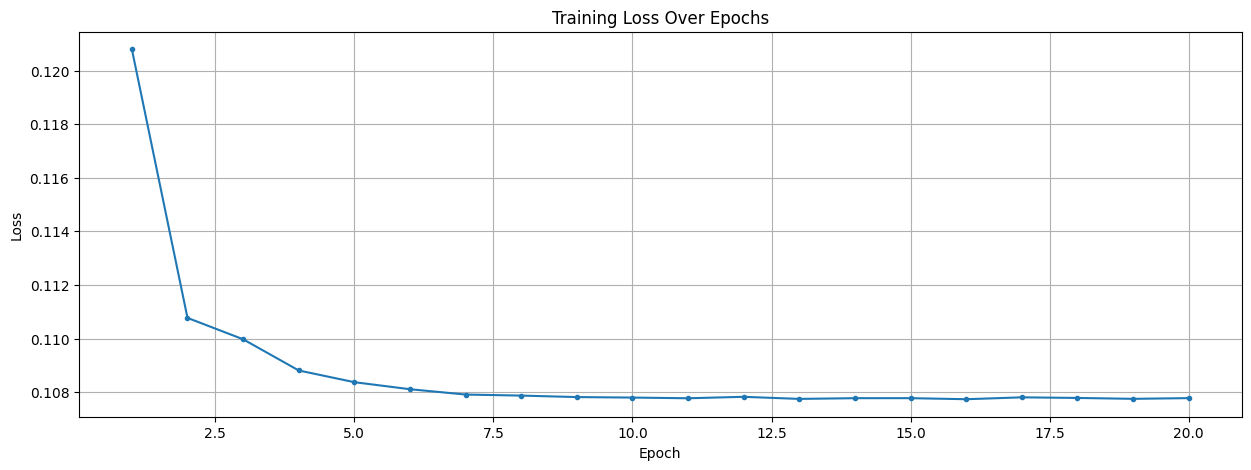

In [44]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), BatchNormModel_loss_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

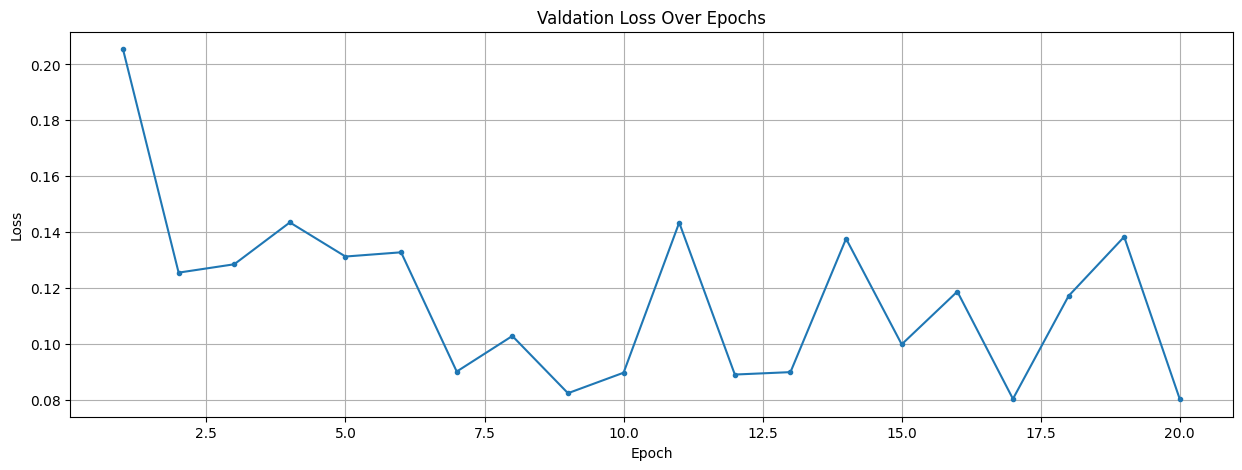

In [45]:
# Plot the validation loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), BatchNormModel_val_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Valdation Loss Over Epochs')
plt.grid(True)
plt.show()

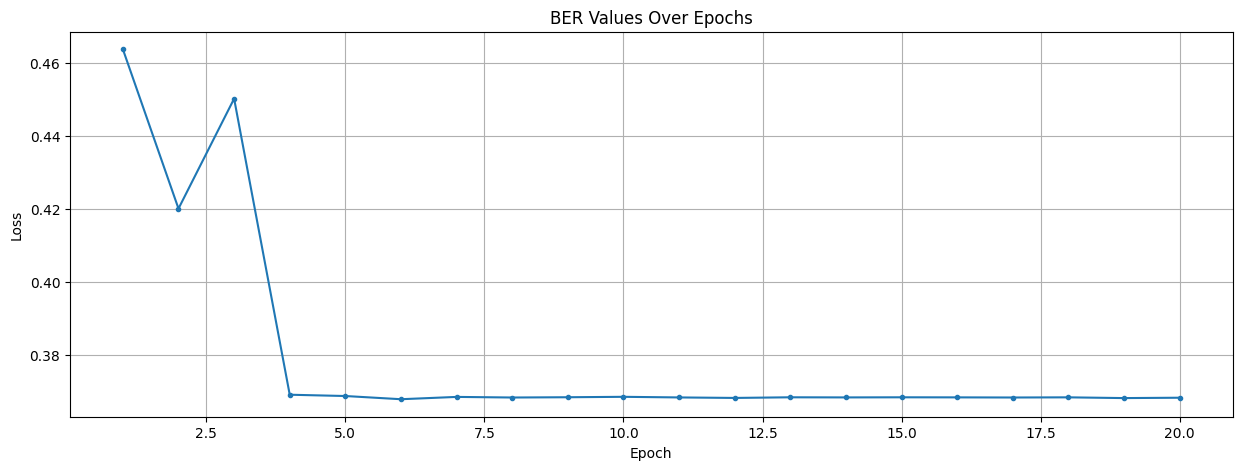

In [46]:
# Plot the BER
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), BatchNormModel_BER_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BER Values Over Epochs')
plt.grid(True)
plt.show()

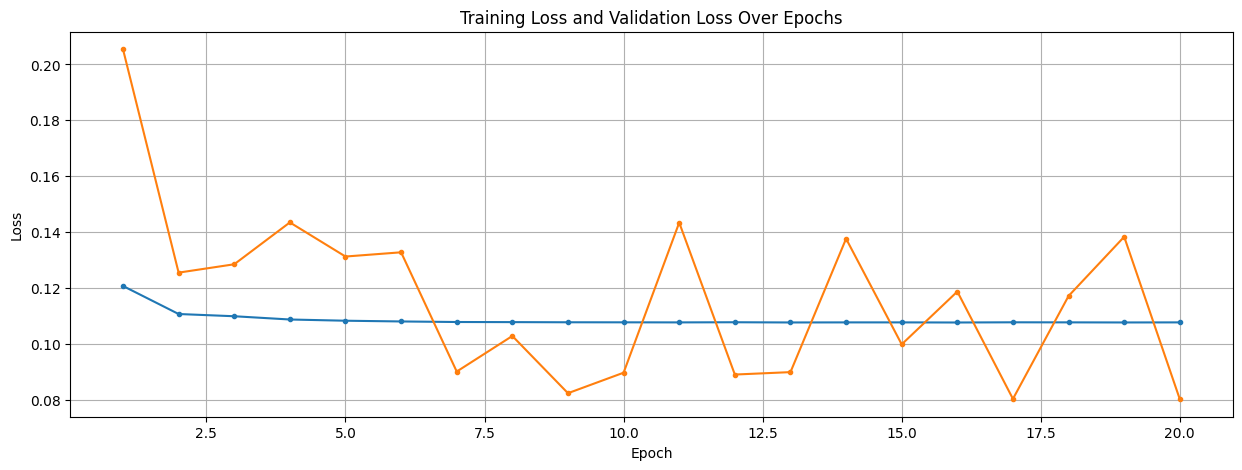

In [48]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), BatchNormModel_loss_values, marker='o',markersize=3)
plt.plot(range(1, num_epochs + 1), BatchNormModel_val_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss Over Epochs')
plt.grid(True)
plt.show()

In [50]:
'''
Less Complex Model
'''
torch.cuda.empty_cache()
model = LessComplexModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 20
LessComplexModel_loss_values = []
LessComplexModel_BER_values = []
LessComplexModel_val_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, _, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets.float())  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]  # Bit Error Rate
    with torch.no_grad():
        for inputs, _, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets.float())

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != targets).float()  # Count of unequal bits
            error_rate = error_count / len(targets.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())

    scheduler.step() #adjust learning rate
    avg_loss = running_loss / len(train_loader)
    LessComplexModel_loss_values.append(avg_loss)
    LessComplexModel_val_values.append(val_loss.item())
    BER_avg=np.mean(BER_batch)
    LessComplexModel_BER_values.append(BER_avg)
    print(f"Epoch {epoch + 1}/{num_epochs}, Trainig_Loss: {avg_loss:.4f}, Val_loss: {val_loss:.4f}, BER: {BER_avg:.4f}")
torch.save(model.state_dict(), '/content/drive/MyDrive/CMPE_258_Deep_Learning/CMPE258_HW/models/DropOutModel.pth')

Epoch 1/20, Trainig_Loss: 0.1130, Val_loss: 0.2016, BER: 0.4158
Epoch 2/20, Trainig_Loss: 0.1027, Val_loss: 0.1597, BER: 0.4110
Epoch 3/20, Trainig_Loss: 0.0959, Val_loss: 0.1582, BER: 0.3231
Epoch 4/20, Trainig_Loss: 0.0936, Val_loss: 0.0713, BER: 0.2884
Epoch 5/20, Trainig_Loss: 0.0932, Val_loss: 0.1028, BER: 0.2862
Epoch 6/20, Trainig_Loss: 0.0928, Val_loss: 0.0999, BER: 0.2801
Epoch 7/20, Trainig_Loss: 0.0927, Val_loss: 0.0747, BER: 0.2791
Epoch 8/20, Trainig_Loss: 0.0926, Val_loss: 0.0533, BER: 0.2790
Epoch 9/20, Trainig_Loss: 0.0926, Val_loss: 0.0551, BER: 0.2788
Epoch 10/20, Trainig_Loss: 0.0925, Val_loss: 0.0850, BER: 0.2789
Epoch 11/20, Trainig_Loss: 0.0925, Val_loss: 0.1182, BER: 0.2788
Epoch 12/20, Trainig_Loss: 0.0925, Val_loss: 0.1017, BER: 0.2788
Epoch 13/20, Trainig_Loss: 0.0925, Val_loss: 0.0743, BER: 0.2785
Epoch 14/20, Trainig_Loss: 0.0925, Val_loss: 0.0723, BER: 0.2786
Epoch 15/20, Trainig_Loss: 0.0925, Val_loss: 0.0652, BER: 0.2786
Epoch 16/20, Trainig_Loss: 0.0925,

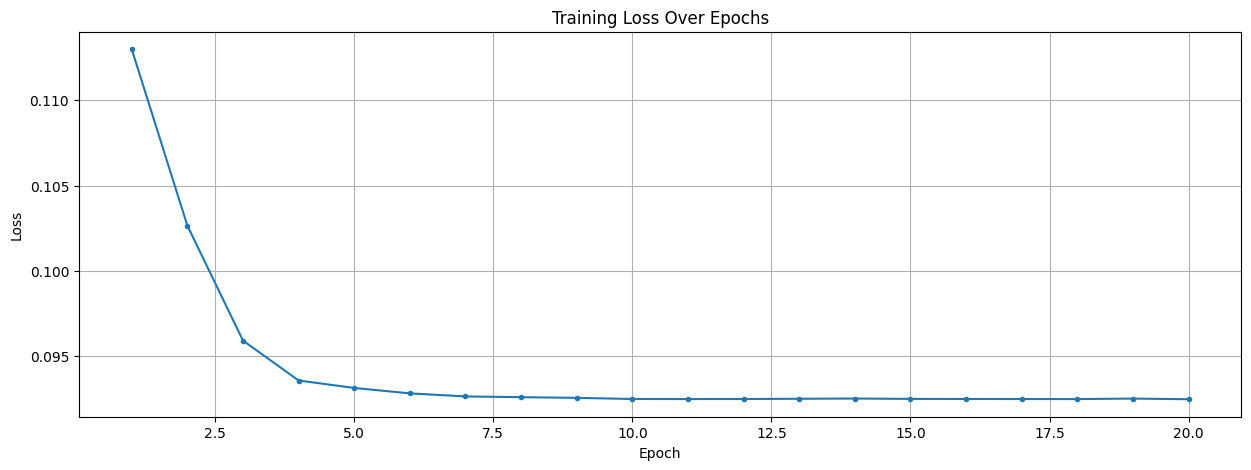

In [51]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), LessComplexModel_loss_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

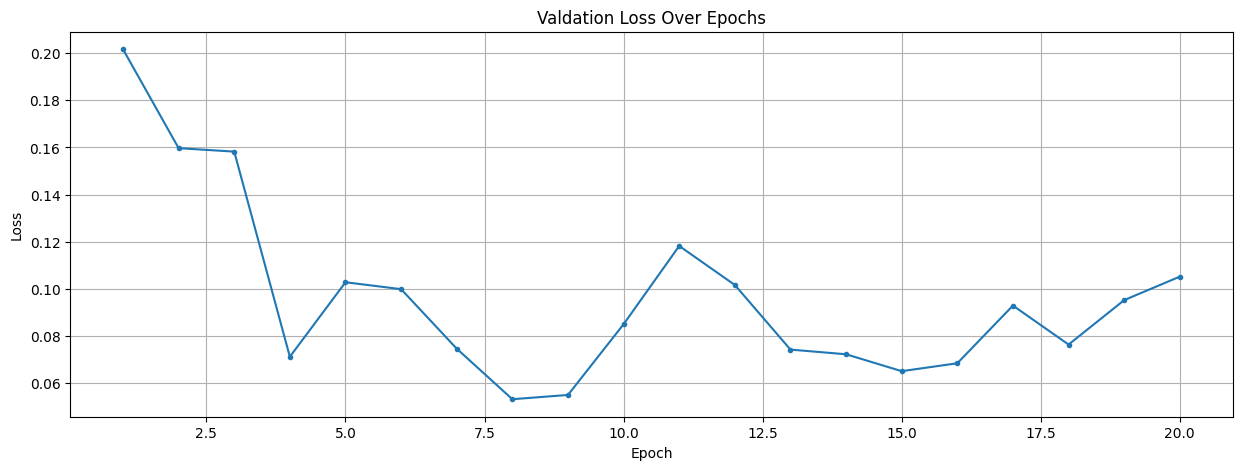

In [52]:
# Plot the validation loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), LessComplexModel_val_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Valdation Loss Over Epochs')
plt.grid(True)
plt.show()

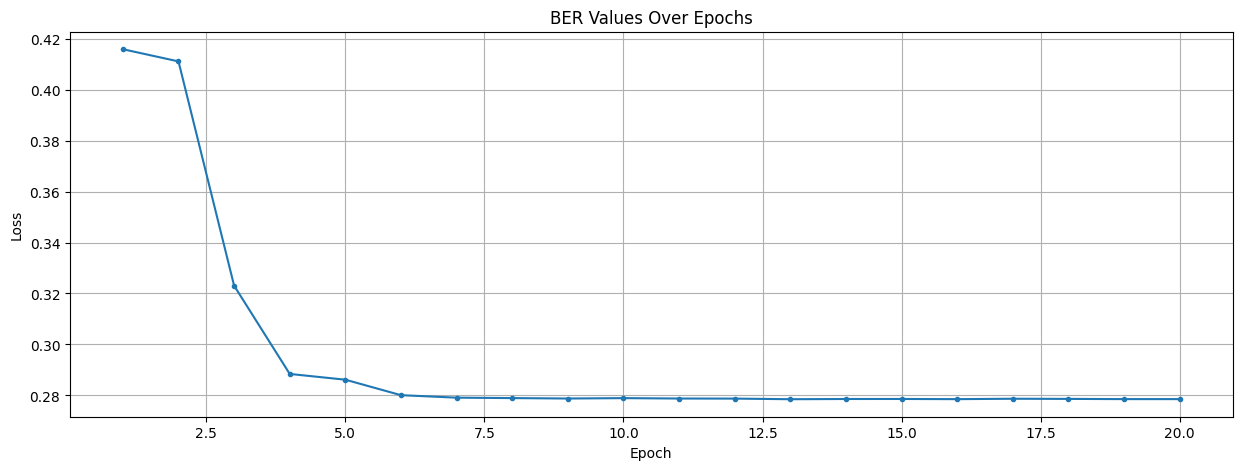

In [53]:
# Plot the BER
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), LessComplexModel_BER_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BER Values Over Epochs')
plt.grid(True)
plt.show()

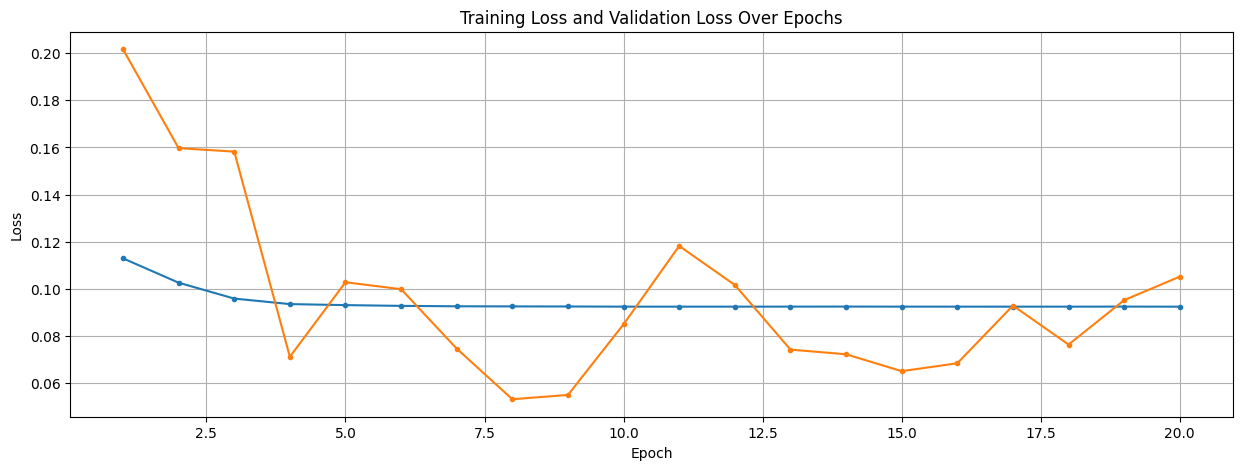

In [54]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), LessComplexModel_loss_values, marker='o',markersize=3)
plt.plot(range(1, num_epochs + 1), LessComplexModel_val_values, marker='o',markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss Over Epochs')
plt.grid(True)
plt.show()

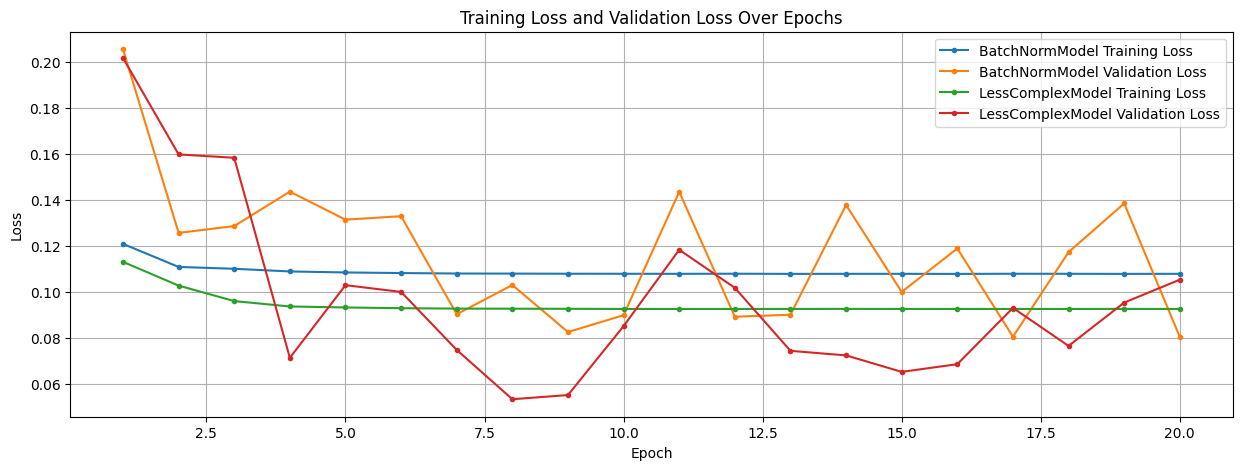

In [56]:
# Plot the training loss
plt.figure(figsize=(15, 5))
plt.plot(range(1, num_epochs + 1), BatchNormModel_loss_values, marker='o', markersize=3, label='BatchNormModel Training Loss')
plt.plot(range(1, num_epochs + 1), BatchNormModel_val_values, marker='o', markersize=3, label='BatchNormModel Validation Loss')
plt.plot(range(1, num_epochs + 1), LessComplexModel_loss_values, marker='o', markersize=3, label='LessComplexModel Training Loss')
plt.plot(range(1, num_epochs + 1), LessComplexModel_val_values, marker='o', markersize=3, label='LessComplexModel Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()